# Lesson 3: Adding Intelligence with Tools
In Lesson 2, you built a climate assistant that could answer general questions from its training data. But it couldn't access real climate datasets or perform calculations.

In this lesson, you'll give your agent the ability to use tools— python functions that extend its capabilities beyond just generating text. You'll transform standalone Python functions into tools that NAT can automatically provide to your LLM, enabling it to analyze real climate data, calculate statistics, and create visualizations.<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; margin: 10px 0;">
<h4 style="margin-top: 0;">🎯 Learning Objectives</h4>
By the end of this lesson, you'll understand how to:
<ul>
<li>Transform existing Python functions into NAT-compatible tools</li>
<li>Register multiple tools with a ReAct agent workflow</li>
<li>See how agents decide which tools to use and when</li>
<li>Build a climate analyzer that can answer complex, data-driven questions</li>
</ul>
</div>

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

# Verify it loaded
print("API key set:", "Yes" if os.getenv('NVIDIA_API_KEY') else "No")

API key set: Yes


## Part 1: Standalone Climate Tools
Before registering tools with NAT, let's explore the Python functions you'll be working with. These are normal Python functions that load data, perform calculations, and generate visualizations—they know nothing about NAT yet.

### Load NOAA Climate Dataset
These functions are designed to:

- Load climate data from CSV files (National Oceanic and Atmospheric Administration (NOAA) temperature records)
- Calculate statistics like mean temperature, trends, and standard deviation
- Filter and analyze data by country or time period
- Create visualizations of temperature trends
- Find patterns like the warmest years on record

In [2]:
import sys
sys.path.append('standalone_tools')

from climate_tools_simple import (
    load_climate_data,
    calculate_statistics,
    filter_by_country,
    find_extreme_years,
    create_visualization,
    list_countries
)

Let's load the dataset and see what we're working with:

In [3]:
import pandas as pd

df = load_climate_data("../resources/climate_data/temperature_annual.csv")
print(f"Loaded {len(df)} temperature records")
print(f"Years covered: {df['year'].min()}-{df['year'].max()}")
print(f"Countries: {df['country_name'].nunique()}")

Loaded 1210 temperature records
Years covered: 1950-2025
Countries: 10


<div style="background-color: #f3e5f5; border-left: 6px solid #9c27b0; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">💡 What to Expect</h4>
The dataframe contains NOAA's annual temperature anomaly data—deviations from the 20th-century average temperature. Positive values mean warmer than average, negative means cooler.
</div>

### Test Individual Functions
Each function is designed with a single, clear purpose. Let's test them individually:

In [4]:
print(calculate_statistics.__doc__)


    Calculate basic statistics from temperature data.
    
    Args:
        df: DataFrame with temperature data
        country: Optional country name to filter by
        
    Returns:
        JSON string with statistics
    


<div style="background-color: #fff3cd; border-left: 6px solid #ffc107; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">📖 Why Docstrings Matter</h4>
Good docstrings are critical because NAT will use them to help the LLM understand what each tool does, when to use it, and what parameters it needs.
</div>

In [5]:
# Calculate global climate statistics
global_stats = calculate_statistics(df)
print("Global temperature statistics:")
print(global_stats)

Global temperature statistics:
{
  "mean_temperature": 17.91,
  "min_temperature": -15.71,
  "max_temperature": 29.23,
  "std_deviation": 7.83,
  "num_records": 1210,
  "trend_per_decade": 0.241,
  "years_analyzed": "1950-2025"
}


In [6]:
print(create_visualization.__doc__)


    Create climate data visualizations and save to file.
    
    Args:
        df: Temperature data DataFrame
        plot_type: Type of plot ('annual_trend', 'country_comparison', 'monthly_pattern')
        country: Optional country to focus on
        save_path: Path to save the plot
        
    Returns:
        Description of what was plotted
    


In [7]:
# Create a global temperature trend visualization
result = create_visualization(df, plot_type="annual_trend", save_path="global_trend.png")
print(result)

Created annual_trend plot and saved to global_trend.png


<div style="background-color: #f3e5f5; border-left: 6px solid #9c27b0; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">💡 What You'll See</h4>
A line chart showing how global temperatures have changed over time. The visualization function saves the plot to a file and returns a JSON confirmation.
</div>

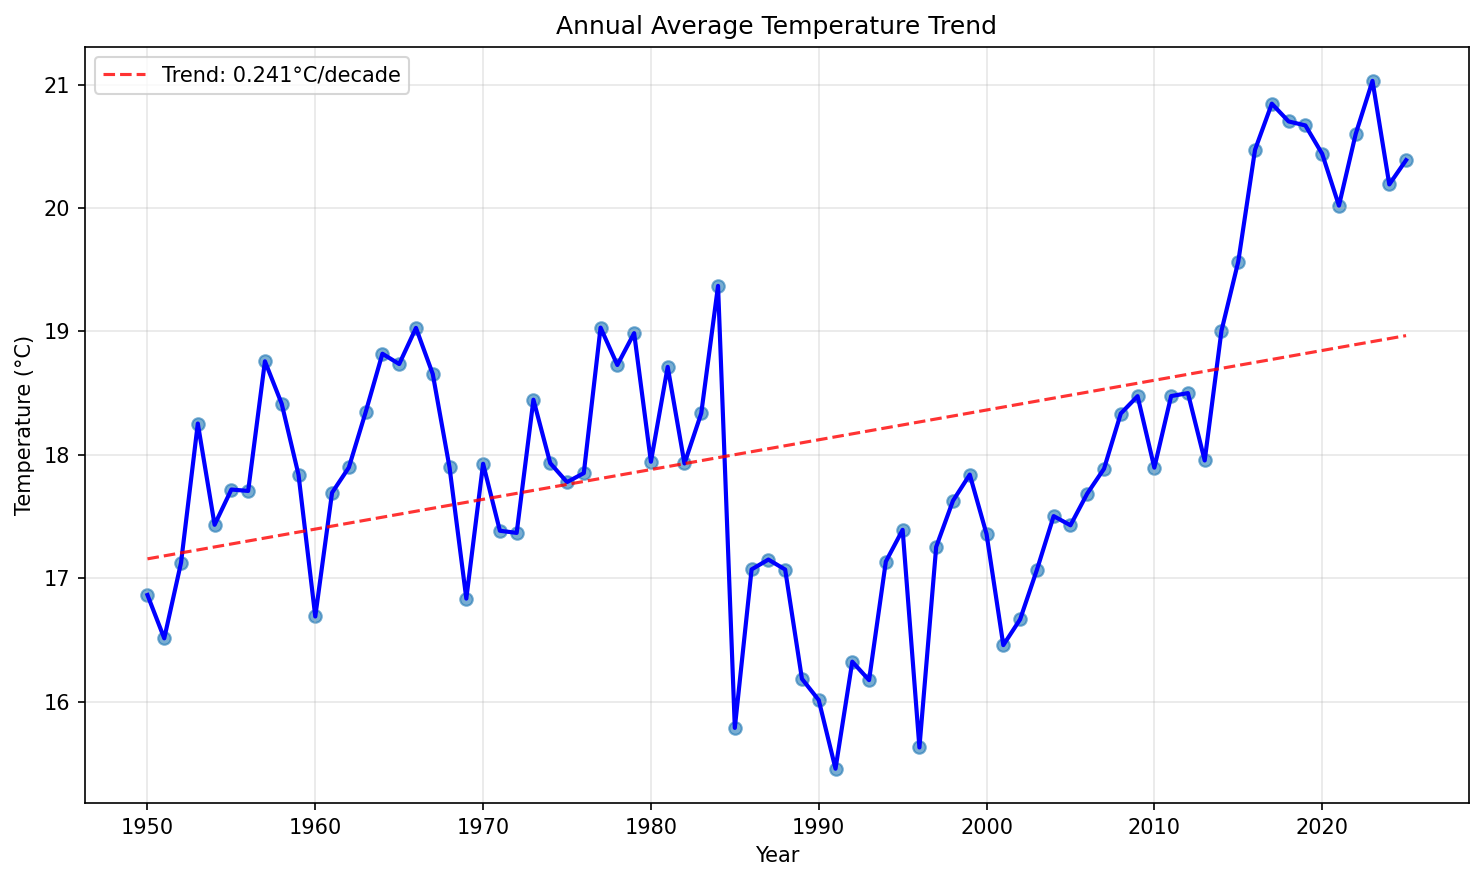

In [8]:
# Display the plot
from IPython.display import Image
Image("global_trend.png")

### The Tool Design Pattern
Notice how these functions follow a specific pattern:
<div style="background-color: #f0f0f0; padding: 15px; border-radius: 8px; margin: 20px 0;">
<h4>✅ Tool Design Pattern Checklist</h4>
<table style="width: 100%; border-collapse: collapse;">
    <tr style="background-color: #4CAF50; color: white;">
        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Pattern Element</th>
        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Why It Matters</th>
    </tr>
    <tr style="background-color: white;">
        <td style="padding: 12px; border: 1px solid #ddd;"><strong>Returns JSON</strong></td>
        <td style="padding: 12px; border: 1px solid #ddd;">Easy for LLMs to parse and extract information</td>
    </tr>
    <tr style="background-color: #f9f9f9;">
        <td style="padding: 12px; border: 1px solid #ddd;"><strong>Single Responsibility</strong></td>
        <td style="padding: 12px; border: 1px solid #ddd;">Clear purpose makes tool selection easier for agent</td>
    </tr>
    <tr style="background-color: white;">
        <td style="padding: 12px; border: 1px solid #ddd;"><strong>Clear Docstrings</strong></td>
        <td style="padding: 12px; border: 1px solid #ddd;">Helps LLM understand when and how to use the tool</td>
    </tr>
    <tr style="background-color: #f9f9f9;">
        <td style="padding: 12px; border: 1px solid #ddd;"><strong>Predictable Structure</strong></td>
        <td style="padding: 12px; border: 1px solid #ddd;">Consistent patterns reduce agent confusion</td>
    </tr>
</table>
</div>

<div style="background-color: #ffebee; border-left: 6px solid #f44336; padding: 15px; margin: 20px 0;">
<h4 style="margin-top: 0;">⚠️ The Problem</h4>
LLMs can't call these functions directly. They're just Python code sitting in a file. Before you can use them, you need to register them with NAT so your agent knows:
<ol>
<li>What tools are available</li>
<li>What each tool does</li>
<li>What parameters they accept</li>
<li>How to call them</li>
</ol>
That's what you'll do next.
</div>

## Part 2: NAT Tool Registration
To make your Python functions available to an LLM, you need three components:
<div style="background-color: #f9f9f9; border: 2px solid #ddd; padding: 15px; border-radius: 8px; margin: 20px 0;">
<h4 style="text-align: center; margin-bottom: 15px;">Tool Registration Flow</h4>
<div style="display: flex; flex-direction: column; gap: 10px; max-width: 600px; margin: 0 auto;">
    <div style="display: flex; align-items: center; gap: 8px;">
        <div style="background-color: #4CAF50; color: white; padding: 10px; border-radius: 5px; flex: 1; text-align: center;">
            <strong>1. Input Schema</strong><br><small>Define parameters</small>
        </div>
        <span style="font-size: 20px;">→</span>
        <div style="background-color: #2196F3; color: white; padding: 10px; border-radius: 5px; flex: 1; text-align: center;">
            <strong>2. Config Class</strong><br><small>Register name</small>
        </div>
    </div>
    <div style="text-align: center; font-size: 20px;">↓</div>
    <div style="display: flex; align-items: center; gap: 8px;">
        <div style="background-color: #FF9800; color: white; padding: 10px; border-radius: 5px; flex: 1; text-align: center;">
            <strong>3. Wrapper Function</strong><br><small>Make async & callable</small>
        </div>
        <span style="font-size: 20px;">→</span>
        <div style="background-color: #9C27B0; color: white; padding: 10px; border-radius: 5px; flex: 1; text-align: center;">
            <strong>YAML Config</strong><br><small>Reference in workflow</small>
        </div>
    </div>
</div>
</div>
Let's walk through registering a single tool, then you'll learn how to register all of them.

### Step 1: Define Input Schema

```python
from pydantic import BaseModel, Field

class CalculateStatsInput(BaseModel):
    country: str = Field(
        default="",
        description="Country name to filter by (e.g., 'United States', 'France'). Leave empty for global statistics."
    )
```

<div style="background-color: #f3e5f5; border-left: 6px solid #9c27b0; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">💡 What This Does</h4>
Defines what parameters the LLM can pass to your function. The <code>description</code> is critical—NAT includes it in the tool description sent to the LLM to help it understand how to use the parameter.
<br><br>
<strong>Example:</strong> If the user asks "What's the temperature trend in France?", the LLM knows to pass <code>country="France"</code>.
</div>

### Step 2: Create Config Class

```python
from nat.data_models.function import FunctionBaseConfig

class CalculateStatisticsConfig(FunctionBaseConfig, name="simple_calculate_statistics"):  
    """Configuration for calculating climate statistics."""
    pass
```

<div style="background-color: #f3e5f5; border-left: 6px solid #9c27b0; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">💡 What This Does</h4>
Stores a unique name for this tool. In your YAML config, you'll reference this tool as <code>climate_analyzer/calculate_statistics</code> (package_name/tool_name).
</div>

The config class can also store additional settings if needed, but for simple tools, it's just a name declaration.

### Step 3: Register the Tool

```python
from nat.builder.builder import Builder
from nat.builder.function_info import FunctionInfo
from nat.cli.register_workflow import register_function

@register_function(config_type=CalculateStatisticsConfig)
async def calculate_statistics_tool(config: CalculateStatisticsConfig, builder: Builder):
    """Register tool for calculating climate statistics."""
    df = load_climate_data(DATA_PATH)
    
    async def _wrapper(country: str = "") -> str:
        country_param = None if country == "" else country
        result = calculate_statistics(df, country_param)
        return result
    
    yield FunctionInfo.from_fn(
        _wrapper,
        input_schema=CalculateStatsInput,
        description=("Calculate temperature statistics globally or for a specific country. "
                     "Returns JSON with: mean_temperature (°C), min_temperature (°C), max_temperature (°C), "
                     "std_deviation (°C), num_records (count), trend_per_decade (°C/decade), "
                     "years_analyzed (e.g. '1950-2025'), and country (if specified).")
    )
```

<div style="background-color: #f3e5f5; border-left: 6px solid #9c27b0; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">💡 What's Happening Here?</h4>
<ol>
<li><strong>@register_function</strong> decorator - Tells NAT "this is a tool"</li>
<li><strong>Load data once</strong> - The outer function loads climate data when the workflow starts</li>
<li><strong>_wrapper function</strong> - This is what the LLM actually calls. It's async because agents might call multiple tools concurrently</li>
<li><strong>FunctionInfo.from_fn</strong> - Tells NAT:
    <ul>
        <li>What function to call (<code>_wrapper</code>)</li>
        <li>What inputs it accepts (<code>CalculateStatsInput</code>)</li>
        <li>How to describe it to the LLM (detailed <code>description</code> string)</li>
    </ul>
</li>
</ol>
<br>
<strong>The description is crucial</strong>—it tells the LLM when to use this tool, what it returns, and what parameters it needs.
</div>

### View the Full Registration File
To see the complete registration code for all tools, open the file `simple_tool_demo/src/simple_tool_demo/register.py`. 

## Config
Run this cell to import the YAML config into your notebook.

The `%load` command reads the file and displays it here so you can see and edit the configuration directly.

In [ ]:
# %load simple_tool_demo/src/simple_tool_demo/configs/config.yml
# Simple configuration showing how to use our registered tool
llms:
  climate_llm:
    _type: nim
    model_name: meta/llama-3.1-70b-instruct
    base_url: $NVIDIA_BASE_URL 
    api_key: $NVIDIA_API_KEY
    temperature: 0.7
functions:
  simple_calculate_statistics:
    _type: simple_tool_demo/simple_calculate_statistics
    description: "Calculate temperature statistics globally or for a specific country"
workflow:
  _type: react_agent
  tool_names:
    - simple_calculate_statistics
  llm_name: climate_llm
  verbose: true


Your YAML config now includes a `functions` section that references your registered tools.
<div style="background-color: #fff3cd; border-left: 6px solid #ffc107; padding: 15px; margin: 20px 0;">
<h4 style="margin-top: 0;">🔄 ReAct Agent Loop</h4>
<p>Your config now uses <code>_type: react</code> instead of <code>chat_completion</code>. ReAct agents follow a loop:</p>
<div style="margin: 15px 0;">
    <div style="display: flex; align-items: center; margin: 10px 0;">
        <div style="background-color: #ffc107; color: black; padding: 10px; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; font-weight: bold;">1</div>
        <div style="margin-left: 15px;">
            <strong>Think</strong> - Reason about what to do next
        </div>
    </div>
    <div style="display: flex; align-items: center; margin: 10px 0;">
        <div style="background-color: #ffc107; color: black; padding: 10px; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; font-weight: bold;">2</div>
        <div style="margin-left: 15px;">
            <strong>Act</strong> - Call a tool if needed
        </div>
    </div>
    <div style="display: flex; align-items: center; margin: 10px 0;">
        <div style="background-color: #ffc107; color: black; padding: 10px; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; font-weight: bold;">3</div>
        <div style="margin-left: 15px;">
            <strong>Observe</strong> - See the tool's result
        </div>
    </div>
    <div style="display: flex; align-items: center; margin: 10px 0;">
        <div style="background-color: #ffc107; color: black; padding: 10px; border-radius: 50%; width: 40px; height: 40px; display: flex; align-items: center; justify-content: center; font-weight: bold;">4</div>
        <div style="margin-left: 15px;">
            <strong>Repeat</strong> - Until the question is answered
        </div>
    </div>
</div>
</div>

### Install and Run Your ReAct Agent
Since you uninstalled these tools in the previous notebook, you will need to reinstall them here: 

In [10]:
%%capture
# Install our simple tool demo package
!cd simple_tool_demo && pip install -e . && cd ..

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">📦 What This Does</h4>
Installs your package in "editable mode" (<code>-e</code>), so NAT can import your registration functions. Changes you make to the code will be reflected immediately without reinstalling.

In [11]:
!nat run \
  --config_file simple_tool_demo/src/simple_tool_demo/configs/config.yml \
  --input "What is the global temperature trend per decade?"

2025-12-17 19:53:36 - INFO     - nat.cli.commands.start:192 - Starting NAT from config file: 'simple_tool_demo/src/simple_tool_demo/configs/config.yml'
/usr/local/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:171: UserWarning: http://jupyter-api-proxy.internal.dlai/rev-proxy/nvidia does not end in /v1, you may have inference and listing issues. This check will be deprecated in the next release. Please ensure /v1 is appended to the provided URL
  warnings.warn(

Configuration Summary:
--------------------
Workflow Type: react_agent
Number of Functions: 1
Number of Function Groups: 0
Number of LLMs: 1
Number of Embedders: 0
Number of Memory: 0
Number of Object Stores: 0
Number of Retrievers: 0
Number of TTC Strategies: 0
Number of Authentication Providers: 0

2025-12-17 19:53:41 - INFO     - nat.agent.react_agent.agent:169 - 
------------------------------
[AGENT]
Agent input: What is the global temperature trend per decade?
Agent's thoughts: 
Thought: To answer t

</div>
<div style="background-color: #f5f5f5; border: 1px solid #ddd; padding: 15px; border-radius: 5px; margin: 15px 0; font-family: monospace;">
<strong>Expected Output:</strong>
<pre style="margin: 10px 0; white-space: pre-wrap;">
<strong>Thought:</strong> I need to calculate global temperature statistics
<strong>Action:</strong> calculate_statistics(country="")
<strong>Observation:</strong> {"mean_temperature": 0.87, "trend_per_decade": 0.18, ...}
<strong>Final Answer:</strong> The global temperature trend is 0.18°C per decade
</pre>
</div>


In [12]:
# Uninstall our simple tool demo package
!pip uninstall simple_tool_demo -y

Found existing installation: simple_tool_demo 0.1.0
Uninstalling simple_tool_demo-0.1.0:
  Successfully uninstalled simple_tool_demo-0.1.0


<div style="background-color: #fff3cd; border-left: 6px solid #ffc107; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">🗑️ Why Uninstall?</h4>
You're about to install the full <code>climate_analyzer</code> package with all tools. Uninstalling prevents conflicts between the packages.
</div>

<div style="background-color: #e3f2fd; border: 2px solid #2196F3; padding: 20px; border-radius: 8px; margin: 20px 0;">
<h4 style="color: #1976d2; margin-top: 0;">🔑 Registration Pattern</h4>
<p>Every tool follows this five-step pattern:</p>
<ol>
<li><strong>Config Class</strong> - Unique name for the tool</li>
<li><strong>Async Wrapper</strong> - Makes your function callable by the agent</li>
<li><strong>FunctionInfo</strong> - Detailed description for the LLM</li>
<li><strong>YAML Reference</strong> - <code>package_name/tool_name</code> in your config</li>
</ol>
<br>
<div style="background-color: #d4edda; padding: 10px; border-radius: 5px;">
<strong>💡 Pro tip:</strong> Use <code>nat workflow create</code> to generate this scaffolding automatically!
</div>
</div>

### Full Climate Analyzer Package
Now let's register all five climate tools and build a more capable agent. 

In [ ]:
# %load climate_analyzer/src/climate_analyzer/configs/config.yml
# ReAct agent with climate analysis tools

llms:
  climate_llm:
    _type: nim
    model_name: meta/llama-3.1-70b-instruct
    base_url: $NVIDIA_BASE_URL 
    api_key: $NVIDIA_API_KEY
    temperature: 0.7
    top_p: 0.95
    max_tokens: 2048

functions:
  list_countries:
    _type: climate_analyzer/list_countries
    description: "List all available countries in the dataset"
    
  calculate_statistics:
    _type: climate_analyzer/calculate_statistics
    description: "Calculate temperature statistics globally or for a specific country"
  
  filter_by_country:
    _type: climate_analyzer/filter_by_country
    description: "Get information about climate data for a specific country"
  
  find_extreme_years:
    _type: climate_analyzer/find_extreme_years
    description: "Find the warmest or coldest years in the dataset"
  
  create_visualization:
    _type: climate_analyzer/create_visualization
    description: "Create visualizations including automatic top 5 countries by warming trend (country_comparison plot)"

workflow:
  _type: react_agent
  tool_names:
    - list_countries
    - calculate_statistics
    - filter_by_country
    - find_extreme_years
    - create_visualization
  llm_name: climate_llm
  verbose: true
  max_iterations: 5                     # Maximum number of tool-calling cycles before stopping
  parse_agent_response_max_retries: 2   # Retries if agent output can't be parsed (malformed responses)


<div style="background-color: #f3e5f5; border-left: 6px solid #9c27b0; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">🛠️ All Five Tools</h4>
<ul>
<li><strong>calculate_statistics</strong> - Compute temperature metrics</li>
<li><strong>filter_by_country</strong> - Get data for a specific country</li>
<li><strong>find_extreme_years</strong> - Find warmest/coldest years</li>
<li><strong>create_visualization</strong> - Generate charts</li>
<li><strong>list_countries</strong> - Show available countries</li>
</ul>
</div>

In [14]:
%%capture
# Install the package early so it's ready for all subsequent cells
!cd climate_analyzer && pip install -e . && cd ..

### View All Tool Registrations
You can view the file that contains the registration code for all five tools, using the same pattern you learned with calculate_statistics at: `climate_analyzer/src/climate_analyzer/register.py`.

## Part 3: ReAct Agent in Action
Now test your multi-tool agent with increasingly complex questions. Watch how the agent decides which tools to use and in what order.

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> ⚠️
&nbsp; <b>Different Run Results:</b> The output responses generated may differ from those shown in the video.</p>

<div style="background-color: #e8f5e9; border-left: 6px solid #4CAF50; padding: 15px; margin: 20px 0;">
<h4 style="margin-top: 0;">📊 Question 1: Global Trends (Simple)</h4>
<p><strong>Complexity:</strong> <span style="background-color: #4CAF50; color: white; padding: 3px 8px; border-radius: 3px;">Low</span></p>
<p><strong>Expected Tools:</strong> calculate_statistics</p>
<p><strong>Expected Steps:</strong> 1 tool call</p>
</div>

In [15]:
# Ask about global warming trends
!nat run \
  --config_file climate_analyzer/src/climate_analyzer/configs/config.yml \
  --input "What is the global temperature trend per decade?"

2025-12-17 19:53:53 - INFO     - nat.cli.commands.start:192 - Starting NAT from config file: 'climate_analyzer/src/climate_analyzer/configs/config.yml'
2025-12-17 19:53:54 - WARNING  - nat.builder.function_info:455 - Using provided input_schema for multi-argument function
2025-12-17 19:53:54 - WARNING  - nat.builder.function_info:455 - Using provided input_schema for multi-argument function
/usr/local/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:171: UserWarning: http://jupyter-api-proxy.internal.dlai/rev-proxy/nvidia does not end in /v1, you may have inference and listing issues. This check will be deprecated in the next release. Please ensure /v1 is appended to the provided URL
  warnings.warn(

Configuration Summary:
--------------------
Workflow Type: react_agent
Number of Functions: 5
Number of Function Groups: 0
Number of LLMs: 1
Number of Embedders: 0
Number of Memory: 0
Number of Object Stores: 0
Number of Retrievers: 0
Number of TTC Strategies: 0
Numbe

<div style="background-color: #f5f5f5; border: 1px solid #ddd; padding: 15px; border-radius: 5px; margin: 15px 0; font-family: monospace;">
<strong>Expected Behavior:</strong>
<pre style="margin: 10px 0; white-space: pre-wrap;">
1. Agent calls calculate_statistics (no country parameter)
2. Extracts trend_per_decade from the result
3. Formats a natural language response
</pre>
</div>

<div style="background-color: #fff3e0; border-left: 6px solid #ff9800; padding: 15px; margin: 20px 0;">
<h4 style="margin-top: 0;">📊 Question 2: Country Analysis (Moderate)</h4>
<p><strong>Complexity:</strong> <span style="background-color: #ff9800; color: white; padding: 3px 8px; border-radius: 3px;">Medium</span></p>
<p><strong>Expected Tools:</strong> filter_by_country, calculate_statistics</p>
<p><strong>Expected Steps:</strong> 2 tool calls</p>
</div>

In [16]:
# Ask about a specific country
!nat run \
  --config_file climate_analyzer/src/climate_analyzer/configs/config.yml \
  --input "Tell me about France's climate data. How many stations does it have and what's the temperature trend?"

2025-12-17 19:54:09 - INFO     - nat.cli.commands.start:192 - Starting NAT from config file: 'climate_analyzer/src/climate_analyzer/configs/config.yml'
2025-12-17 19:54:10 - WARNING  - nat.builder.function_info:455 - Using provided input_schema for multi-argument function
2025-12-17 19:54:10 - WARNING  - nat.builder.function_info:455 - Using provided input_schema for multi-argument function
/usr/local/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:171: UserWarning: http://jupyter-api-proxy.internal.dlai/rev-proxy/nvidia does not end in /v1, you may have inference and listing issues. This check will be deprecated in the next release. Please ensure /v1 is appended to the provided URL
  warnings.warn(

Configuration Summary:
--------------------
Workflow Type: react_agent
Number of Functions: 5
Number of Function Groups: 0
Number of LLMs: 1
Number of Embedders: 0
Number of Memory: 0
Number of Object Stores: 0
Number of Retrievers: 0
Number of TTC Strategies: 0
Numbe

<div style="background-color: #f5f5f5; border: 1px solid #ddd; padding: 15px; border-radius: 5px; margin: 15px 0; font-family: monospace;">
<strong>Expected Behavior:</strong>
<pre style="margin: 10px 0; white-space: pre-wrap;">
1. Agent calls filter_by_country with country="France"
2. Calls calculate_statistics with country="France"
3. Combines information from both tools
4. Formats a comprehensive answer
</pre>
</div>
<div style="background-color: #f3e5f5; border-left: 6px solid #9c27b0; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">💡 Why Two Tools?</h4>
The agent realizes it needs both station count (from filter) and temperature trend (from statistics) to fully answer the question. This is ReAct reasoning in action.
</div>

<div style="background-color: #fff3e0; border-left: 6px solid #ff9800; padding: 15px; margin: 20px 0;">
<h4 style="margin-top: 0;">📊 Question 3: Visualizations (Moderate)</h4>
<p><strong>Complexity:</strong> <span style="background-color: #ff9800; color: white; padding: 3px 8px; border-radius: 3px;">Medium</span></p>
<p><strong>Expected Tools:</strong> create_visualization</p>
<p><strong>Expected Steps:</strong> 1 tool call + file generation</p>
</div>

In [17]:
# Ask for a visualization
!nat run \
  --config_file climate_analyzer/src/climate_analyzer/configs/config.yml \
  --input "Create a visualization showing which countries have the highest warming trends."

2025-12-17 19:54:26 - INFO     - nat.cli.commands.start:192 - Starting NAT from config file: 'climate_analyzer/src/climate_analyzer/configs/config.yml'
2025-12-17 19:54:26 - WARNING  - nat.builder.function_info:455 - Using provided input_schema for multi-argument function
2025-12-17 19:54:26 - WARNING  - nat.builder.function_info:455 - Using provided input_schema for multi-argument function
/usr/local/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:171: UserWarning: http://jupyter-api-proxy.internal.dlai/rev-proxy/nvidia does not end in /v1, you may have inference and listing issues. This check will be deprecated in the next release. Please ensure /v1 is appended to the provided URL
  warnings.warn(

Configuration Summary:
--------------------
Workflow Type: react_agent
Number of Functions: 5
Number of Function Groups: 0
Number of LLMs: 1
Number of Embedders: 0
Number of Memory: 0
Number of Object Stores: 0
Number of Retrievers: 0
Number of TTC Strategies: 0
Numbe

<div style="background-color: #f5f5f5; border: 1px solid #ddd; padding: 15px; border-radius: 5px; margin: 15px 0; font-family: monospace;">
<strong>Expected Behavior:</strong>
<pre style="margin: 10px 0; white-space: pre-wrap;">
1. Agent calls create_visualization with plot_type="country_trends"
2. Receives confirmation that plot was saved
3. Tells user where to find the image
</pre>
</div>
<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">📁 View the Generated Image</h4>
The image is saved to disk. 
</div>

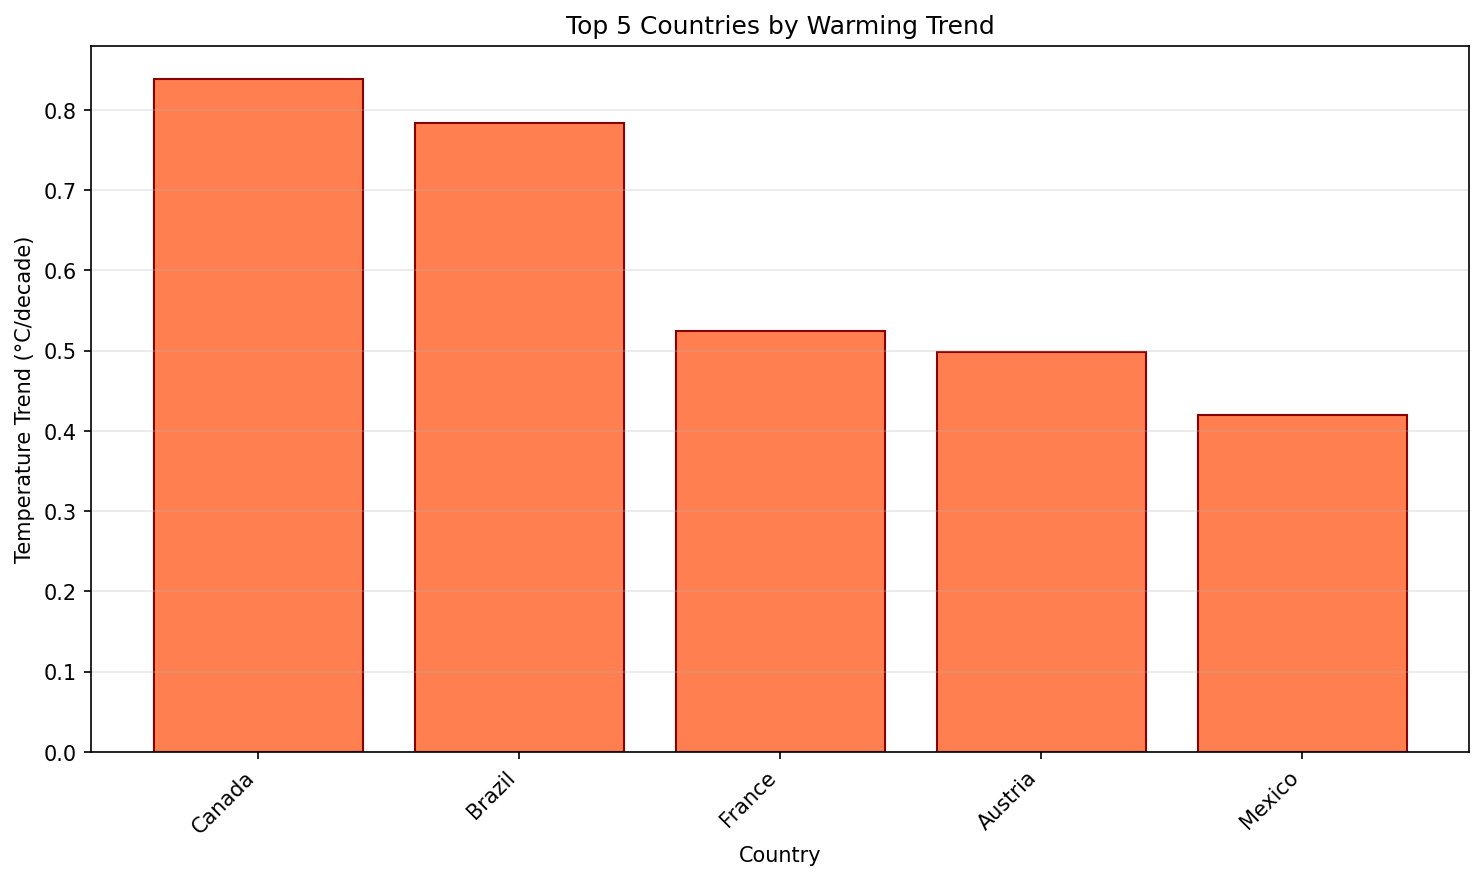

In [18]:
# Display the plot
from IPython.display import Image
Image("climate_plot.png")

<div style="background-color: #ffebee; border-left: 6px solid #f44336; padding: 15px; margin: 20px 0;">
<h4 style="margin-top: 0;">📊 Question 4: Multi-Step Analysis (Complex)</h4>
<p><strong>Complexity:</strong> <span style="background-color: #f44336; color: white; padding: 3px 8px; border-radius: 3px;">High</span></p>
<p><strong>Expected Tools:</strong> calculate_statistics (2x), create_visualization</p>
<p><strong>Expected Steps:</strong> 3+ tool calls</p>
</div>

In [19]:
# Complex question requiring multiple tools
!nat run \
  --config_file climate_analyzer/src/climate_analyzer/configs/config.yml \
  --input "Compare the temperature trends of Canada and Brazil. Which one is warming faster? Also create a visualization of global trends."

2025-12-17 19:54:40 - INFO     - nat.cli.commands.start:192 - Starting NAT from config file: 'climate_analyzer/src/climate_analyzer/configs/config.yml'
2025-12-17 19:54:40 - WARNING  - nat.builder.function_info:455 - Using provided input_schema for multi-argument function
2025-12-17 19:54:40 - WARNING  - nat.builder.function_info:455 - Using provided input_schema for multi-argument function
/usr/local/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:171: UserWarning: http://jupyter-api-proxy.internal.dlai/rev-proxy/nvidia does not end in /v1, you may have inference and listing issues. This check will be deprecated in the next release. Please ensure /v1 is appended to the provided URL
  warnings.warn(

Configuration Summary:
--------------------
Workflow Type: react_agent
Number of Functions: 5
Number of Function Groups: 0
Number of LLMs: 1
Number of Embedders: 0
Number of Memory: 0
Number of Object Stores: 0
Number of Retrievers: 0
Number of TTC Strategies: 0
Numbe

<div style="background-color: #f5f5f5; border: 1px solid #ddd; padding: 15px; border-radius: 5px; margin: 15px 0; font-family: monospace;">
<strong>Expected Behavior:</strong>
<pre style="margin: 10px 0; white-space: pre-wrap;">
1. Agent calls calculate_statistics with country="Canada"
2. Agent calls calculate_statistics with country="Brazil"
3. Compares the trend_per_decade values
4. Agent calls create_visualization for global trends
5. Synthesizes all results into a cohesive answer
</pre>
</div>
<div style="background-color: #e8f5e9; border-left: 6px solid #4CAF50; padding: 15px; margin: 15px 0;">
<h4 style="margin-top: 0;">🌟 This is Where ReAct Shines</h4>
The agent breaks down a complex question into multiple steps, using the right tools in sequence to build up a complete answer. It doesn't just call one tool—it orchestrates multiple tools to solve the problem.
</div>

## Clean Up
Remove generated visualizations so they don't clutter your workspace.

In [20]:
# Clean up any generated plots
!rm -f global_trend.png country_trends.png climate_plot.png

**Why uninstall?** In later lessons, you'll modify this package. Uninstalling ensures you're always working with the latest version.

In [21]:
# Uninstall workflow to avoid conflicts later in the course
!pip uninstall climate_analyzer -y

Found existing installation: climate_analyzer 0.1.0
Uninstalling climate_analyzer-0.1.0:
  Successfully uninstalled climate_analyzer-0.1.0


## Summary
<div style="background-color: #e3f2fd; border: 2px solid #2196F3; padding: 20px; border-radius: 8px; margin: 20px 0;">
<h3 style="color: #1976d2; margin-top: 0;">🎉 Summary: What You Built</h3>
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin: 20px 0;">
    <div style="background-color: white; padding: 15px; border-radius: 5px;">
        <h4 style="color: #4CAF50; margin-top: 0;">✅ Capabilities Added</h4>
        <ul>
            <li>Analyze real NOAA climate data</li>
            <li>Calculate temperature statistics</li>
            <li>Generate visualizations</li>
            <li>Handle multi-step queries</li>
            <li>Compare country-specific trends</li>
        </ul>
    </div>
    <div style="background-color: white; padding: 15px; border-radius: 5px;">
        <h4 style="color: #2196F3; margin-top: 0;">🔧 Tools Registered</h4>
        <ul>
            <li>calculate_statistics</li>
            <li>filter_by_country</li>
            <li>find_extreme_years</li>
            <li>create_visualization</li>
            <li>list_countries</li>
        </ul>
    </div>
</div>
<div style="background-color: white; padding: 15px; border-radius: 5px; margin-top: 15px;">
<h4 style="color: #9C27B0; margin-top: 0;">🧠 Key Concepts Learned</h4>
<ol>
<li><strong>Tool Pattern</strong> - Python Function → Input Schema → Config → Registration → YAML</li>
<li><strong>ReAct Loop</strong> - Agents think, act, observe, and repeat until they solve the problem</li>
<li><strong>Tool Descriptions</strong> - The LLM uses your descriptions to decide when and how to call tools</li>
<li><strong>Multi-tool Coordination</strong> - Agents can use multiple tools in sequence to answer complex questions</li>
</ol>
</div>
<div style="background-color: #fff3cd; padding: 15px; border-radius: 5px; margin-top: 15px;">
<h4 style="margin-top: 0;">⚠️ Current Limitation</h4>
You can't see inside the agent's decision-making process. When the agent makes a mistake, it's hard to debug because you don't know:
<ul>
<li>Which tools it considered but didn't use</li>
<li>Why it chose specific tools over others</li>
<li>What data was passed between tools</li>
<li>Where errors or hallucinations occurred</li>
</ul>
</div>
<div style="background-color: #d4edda; padding: 15px; border-radius: 5px; margin-top: 15px;">
<h4 style="margin-top: 0;">🚀 Next Lesson: Add Observability</h4>
You'll add Phoenix tracing to see:
<ul>
<li>The agent's complete reasoning process</li>
<li>Which tools were considered vs. which were called</li>
<li>Exact prompts sent to the LLM at each step</li>
<li>Tool inputs, outputs, and execution time</li>
<li>Where the agent gets confused or makes mistakes</li>
</ul>
This visibility is critical for debugging and improving agent performance.
</div>
</div>